In [121]:
from google.cloud import bigquery
from google.cloud import storage
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot  as plt
import math

In [122]:
isLastUpdate=False
label='severity_id'
labelName='severity_name'

removeCols=['id','updated_at','imported_at']

dateCols=['open_datetime','close_datetime','response_datetime','resolved_datetime']

numbericCols=['count_detail','open_to_close_hour','open_to_response_hour','response_to_resolved_hour']
#numbericCols=['count_detail','open_to_close_hour']

cateCols=['sla','product_type','brand','service_type','incident_type']

In [123]:
def load_data_bq(sql:str):
 client_bq = bigquery.Client()
 query_result=client_bq.query(sql)
 df_all=query_result.to_dataframe()
 return df_all

In [124]:
sql_all="""

SELECT  id,
severity_id,severity_name,
count_detail,sla,
product_type,brand,service_type,incident_type,
open_datetime,  close_datetime, response_datetime,resolved_datetime, 
updated_at,imported_at
FROM `pongthorn.SMartDW.incident` WHERE open_datetime > '2000-01-01'

order by imported_at

"""

if isLastUpdate:
    print("Load data from Bigquery")
    df_all=load_data_bq(sql_all)
    if len(df_all)>0:
     df_all.to_csv('Incident.csv',index=False)
    else:
     print("No records from bigquery")   
else:
    print("Load data from Load CSV")
    df_all=pd.read_csv('Incident.csv',parse_dates=dateCols)
    
df_all=df_all.drop_duplicates(subset=['id'],keep='first')

df_all.info()


Load data from Load CSV
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2252 entries, 0 to 2255
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 2252 non-null   int64         
 1   severity_id        2252 non-null   int64         
 2   severity_name      2252 non-null   object        
 3   count_detail       2252 non-null   int64         
 4   sla                2252 non-null   object        
 5   product_type       2252 non-null   object        
 6   brand              2252 non-null   object        
 7   service_type       2252 non-null   object        
 8   incident_type      2252 non-null   object        
 9   open_datetime      2252 non-null   datetime64[ns]
 10  close_datetime     2252 non-null   datetime64[ns]
 11  response_datetime  2252 non-null   datetime64[ns]
 12  resolved_datetime  2252 non-null   datetime64[ns]
 13  updated_at         2252 non-null   obje

# Manage Numberic Cols

In [125]:
start_end_list=[ ['open_datetime','close_datetime'],['open_datetime','response_datetime'],['response_datetime','resolved_datetime']]
listDiffDateDeltaCols=[]
listDiffHourCols=[]
for item  in  start_end_list:
   diff_str=f"{item[0]}_to_{item[1]}" 
   diff_str=diff_str.replace('_datetime','')  
   listDiffDateDeltaCols.append(diff_str)
   df_all[diff_str]=df_all[item[1]]-df_all[item[0]]
    
   diff_hour=f'{diff_str}_hour'
   listDiffHourCols.append(diff_hour)
   df_all[diff_hour] = df_all[diff_str].apply(lambda x:  x.total_seconds() / (60*60) if x is not np.nan else np.nan  )
xScoreDiffHourCols=[]
for col in listDiffHourCols:
  z_col=f"zscore_{col}"   
  df_all[z_col] = np.abs(stats.zscore(df_all[col]))   
  xScoreDiffHourCols.append(z_col)  
#remove oulier
threshold_x_sd = 2
for col in  xScoreDiffHourCols:
  df_all=df_all.query(f"{col}<@threshold_x_sd")

In [126]:
# Find any rows  contain 0
allRows=df_all.shape[0]
for col in numbericCols:
    zeroRows=len(df_all.query(f"{col}==0"))
    pctZeroHour=round(zeroRows/allRows*100,1)
    print(f"No. 0-hour row on {col} = {zeroRows}({pctZeroHour} %)")

No. 0-hour row on count_detail = 114(5.2 %)
No. 0-hour row on open_to_close_hour = 1(0.0 %)
No. 0-hour row on open_to_response_hour = 427(19.6 %)
No. 0-hour row on response_to_resolved_hour = 88(4.0 %)


In [127]:
def explore_ranges_numberic_val(col,rangeList):
    print(col)
    rangeList.sort()
    return pd.cut(df_all[col],rangeList, right=True).value_counts()

In [128]:
range1= [0,24, 168, 360, 720,math.floor(df_all['open_to_close_hour'].max())]
print(explore_ranges_numberic_val('open_to_close_hour',range1))
print("=======================================================")

range2= [0,4, 8, 12, 24,math.floor(df_all['response_to_resolved_hour'].max())]
print(explore_ranges_numberic_val('response_to_resolved_hour',range2))
print("=======================================================")

range3= [0,4, 8, 12, 24,math.floor(df_all['open_to_response_hour'].max())]
print(explore_ranges_numberic_val('open_to_response_hour',range3))
print("=======================================================")

range4= [0,2, 4,math.floor(df_all['count_detail'].max())]
print(explore_ranges_numberic_val('count_detail',range4))
print("=======================================================")

open_to_close_hour
(0, 24]        1500
(24, 168]       438
(168, 360]      113
(720, 1511]      62
(360, 720]       60
Name: open_to_close_hour, dtype: int64
response_to_resolved_hour
(0, 4]        712
(24, 1398]    525
(4, 8]        503
(12, 24]      191
(8, 12]       155
Name: response_to_resolved_hour, dtype: int64
open_to_response_hour
(0, 4]      1624
(12, 24]      43
(4, 8]        32
(24, 74]      26
(8, 12]       22
Name: open_to_response_hour, dtype: int64
count_detail
(0, 2]     1651
(2, 4]      252
(4, 35]     158
Name: count_detail, dtype: int64


In [129]:
print("remove some cate featurs that have imcompelte data")
numColsRemove=['open_to_response_hour','count_detail'] 
numbericCols=[x for x in numbericCols if x not in numColsRemove]   
numbericCols

remove some cate featurs that have imcompelte data


['open_to_close_hour', 'response_to_resolved_hour']

In [130]:
df_all=df_all.query('response_to_resolved_hour!=0')

In [131]:
removeCols=removeCols+dateCols+xScoreDiffHourCols+listDiffDateDeltaCols+numColsRemove
df_all=df_all.drop(columns=removeCols)
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2087 entries, 0 to 2255
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   severity_id                2087 non-null   int64  
 1   severity_name              2087 non-null   object 
 2   sla                        2087 non-null   object 
 3   product_type               2087 non-null   object 
 4   brand                      2087 non-null   object 
 5   service_type               2087 non-null   object 
 6   incident_type              2087 non-null   object 
 7   open_to_close_hour         2087 non-null   float64
 8   response_to_resolved_hour  2087 non-null   float64
dtypes: float64(2), int64(1), object(6)
memory usage: 163.0+ KB


In [137]:
df_all.describe()

,severity_id,open_to_close_hour,response_to_resolved_hour
count,2087.000000,2087.000000,2087.000000
mean,2.597988,79.448962,57.930762
std,0.842800,209.782957,169.336064
min,1.000000,0.166667,0.016667
25%,2.000000,4.158333,3.000000
50%,2.000000,8.600000,6.966667
75%,3.000000,33.983333,24.183333
max,4.000000,1511.600000,1398.916667


D:\ProgramData\Anaconda3\envs\myquant_exp\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
D:\ProgramData\Anaconda3\envs\myquant_exp\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


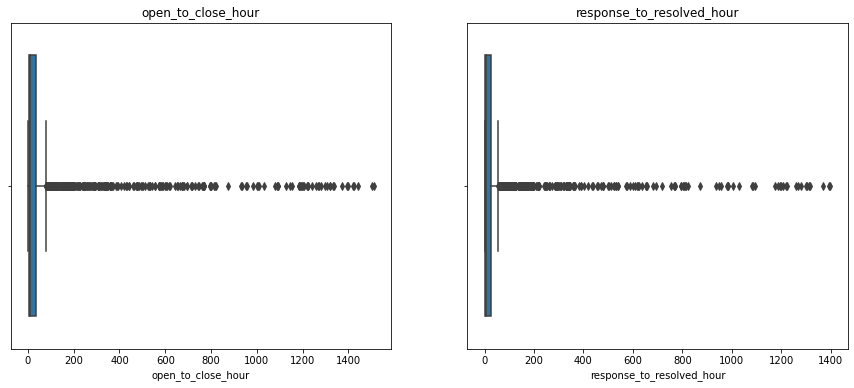

In [135]:
fig, axs = plt.subplots(nrows=1, ncols=len(numbericCols),figsize=(15,6))
idx=0
for col in numbericCols:
  sns.boxplot(df_all[col],ax=axs[idx]).set_title(col)
  idx=idx+1  
plt.show()


array([[<AxesSubplot:title={'center':'open_to_close_hour'}>,
        <AxesSubplot:title={'center':'response_to_resolved_hour'}>]],
      dtype=object)

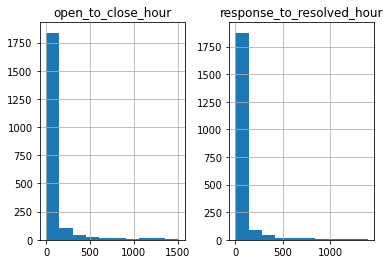

In [136]:
df_all[numbericCols].hist()

# Manage Categorical Cols

In [138]:
df_all[cateCols]

,sla,product_type,brand,service_type,incident_type
0,24x7 4Hrs Response Time,Software,VMWare,Request,General Incident
1,24x7 4Hrs Response Time,Software,Trend Micro,Request,General Incident
2,24x7 4Hrs Resolution Time,Software,VMWare,Request,Upgrade Software
3,24x7 4Hrs Resolution Time,Other,F5,Request,General Incident
4,24x7 4Hrs Resolution Time,Firewall,Palo Alto,Request,General Incident
...,...,...,...,...,...
2251,24x7 4Hrs Resolution Time,Hardware,Oracle,Incident,Hard Disk Drive Failure
2252,24x7 4Hrs Resolution Time,Server,HPE,Incident,General Incident
2253,24x7 4Hrs Resolution Time,Server,HPE,Incident,General Incident
2254,24x7 4Hrs Resolution Time,Storage,NetApp,Incident,General Incident
